In [12]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas_datareader as web
import math
import yfinance as yf
import pandas as pd
import seaborn as sns

In [2]:
#%pip install yfinance

     ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
     --------- ------------------------------ 0.7/2.9 MB 14.4 MB/s eta 0:00:01
     ---------------- ----------------------- 1.2/2.9 MB 13.1 MB/s eta 0:00:01
     ------------------------ --------------- 1.8/2.9 MB 12.5 MB/s eta 0:00:01
     -------------------------------- ------- 2.4/2.9 MB 12.8 MB/s eta 0:00:01
     ---------------------------------------  2.9/2.9 MB 12.5 MB/s eta 0:00:01
     ---------------------------------------- 2.9/2.9 MB 11.0 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/143.0 kB ? eta -:--:--
     ----------------------------------- -- 133.1/14

# Lecture des informations finance depuis Yahoo

In [13]:
etf = ['BZ=F','EURUSD=X','TTF=F'] #,'TTFX23.NYM','TTFZ23.NYM','TTFV23.NYM']
#data = yf.Ticker(etf)
#dataH = data.history(start='2007-01-01',period='1d')
it = yf.download(tickers=etf, period='1d',start='2012-01-01')
it = it.rename(columns = {'EURUSD=X':'€/$'})

[*********************100%***********************]  3 of 3 completed


# Lecture des informations de stock de Gaz depuis AGSI
* normalisation des données
* conversion en float
* conversion des dates

pour un Pays remplacer "type" par "country" et mettre en paramètre le code du pays : FR, BE, DE ...

In [14]:
import requests
params = {
    "type": "EU",
    "from": "2012-01-01",
    "size": 10000
}
header = {
  "x-key" : "99e18f932d22c9acf9c42f27d0b8b539" }

url = "https://agsi.gie.eu/api"
resp = requests.get(url=url, params=params, headers=header)
json = resp.json()
data = pd.json_normalize(json['data'])
data["gasInStorage"] = data["gasInStorage"].astype(float)
#data["coveredCapacity"] = data["coveredCapacity"].astype(float)
pd.to_datetime(data['gasDayStart'], errors='coerce')
#data[["gasDayStart","gasInStorage"]]
#print(data)
print('Done')

Done


### Préparation des données (en mois / années)

In [15]:
import datetime as dt
endData = data[["gasDayStart","gasInStorage"]].copy(deep = True)
endData['Date'] = pd.to_datetime(endData['gasDayStart'],format='%Y-%m-%d', errors='coerce',utc=False)
endData['année'] = endData['Date'].dt.year
endData['mois'] = endData['Date'].dt.month
endData.set_index('Date')

,gasDayStart,gasInStorage,année,mois
Date,,,,
2023-12-13,2023-12-13,1022.8848,2023,12
2023-12-12,2023-12-12,1026.8663,2023,12
2023-12-11,2023-12-11,1030.7395,2023,12
2023-12-10,2023-12-10,1034.3526,2023,12
2023-12-09,2023-12-09,1036.5743,2023,12
...,...,...,...,...
2012-01-05,2012-01-05,547.8834,2012,1
2012-01-04,2012-01-04,550.0136,2012,1
2012-01-03,2012-01-03,552.2452,2012,1


In [16]:
def filtreAnnee(df, a):
    mask_ = (df['année'] == a)
    #mask_ = ((fin['mois'] == 2) & (fin['year'] == 2022))
    return df.loc[mask_]

              gasInStorage     TTF=F      BZ=F
gasInStorage      1.000000  0.014276  0.460836
TTF=F             0.014276  1.000000  0.267803
BZ=F              0.460836  0.267803  1.000000


<AxesSubplot:>

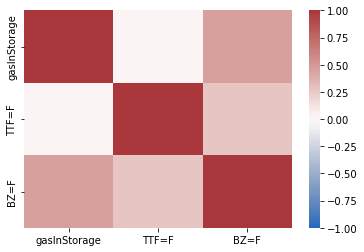

In [17]:
final = pd.merge(endData, it['Close'], how='left', on="Date" )
fin =final.dropna()
# mask_ = (fin['année'] == 2023)
# #mask_ = ((fin['mois'] == 2) & (fin['year'] == 2022))
# fin_ = fin.loc[mask_]
fin_ = filtreAnnee(fin, 2023)
fin_ = (fin_[["gasInStorage","TTF=F","BZ=F","Date"]])
fin_ = fin_.set_index("Date")
print(fin_.corr())
sns.heatmap(fin_.corr(),cmap='vlag', vmin=-1, vmax=1)

Stock maxi sur la période :  1135.6743


<AxesSubplot:xlabel='Date'>

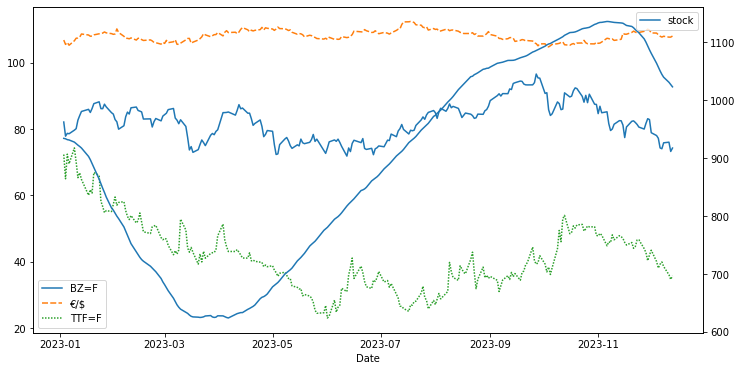

In [18]:
# On fait une copie du DF et on remet les index
# cette copy est filtrée suivant l'année
an = 2023
fin_1 = filtreAnnee(fin,an).copy(deep=True)
fin_2 = filtreAnnee(fin[['gasInStorage','Date','année']],an).copy(deep=True)
fin_1 = fin_1.set_index("Date")
fin_2 = fin_2.set_index("Date")
# On normalise si besoin 
maxi = fin_1["gasInStorage"].max()
print('Stock maxi sur la période : ',maxi)
maxi = 100.0 # si on ne souhaite pas normaliser
# on normalise le stock (100%) et on nettoye ...
fin_2["stock"] = fin_2["gasInStorage"] / maxi * 100.0
# print(fin_1.head())
fin_1['€/$'] = fin_1['€/$'] * 100.0
fin_1 = fin_1.drop(['année','mois','gasDayStart','gasInStorage'], axis=1)
fin_2 = fin_2.drop(['gasInStorage','année'],axis=1)
# on Affiche le graphique
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=fin_1, color='Blue')
ax2 = plt.twinx()
sns.lineplot(data=fin_2, ax=ax2 , color='red')

In [ ]:
fin[0:16]

In [ ]:
fin_ = fin[["gasInStorage","TTF=F","BZ=F","OCT23","NOV23","DEC23","Date"]]
fin_ = fin_.set_index('Date')
sns.heatmap(fin_.corr(), vmin=-1, vmax=1, cmap='vlag')
print(fin_.corr())